
 ======== Loading... =============== 



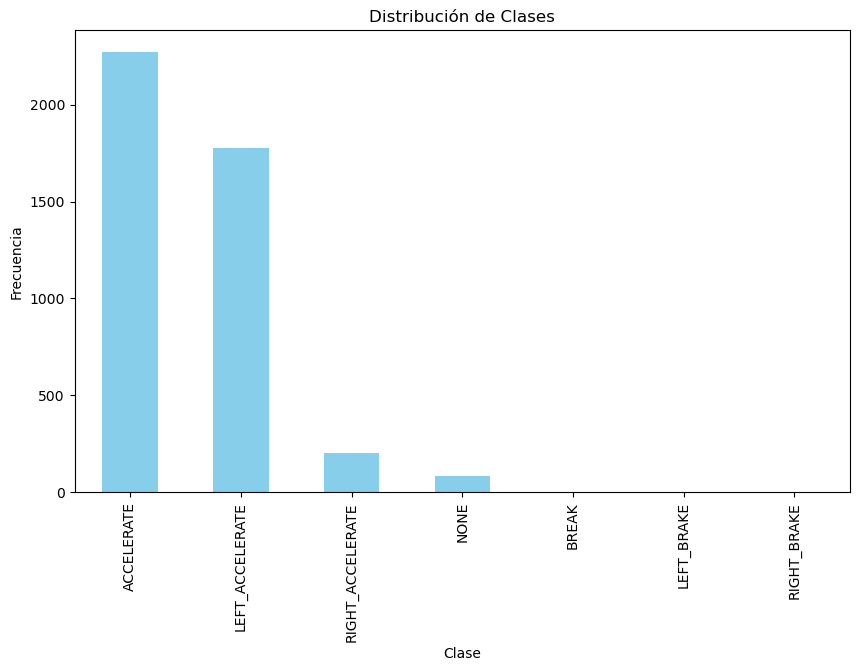


 ===================  SIMILARITY  ===================== 

Vecinos más cercanos:
[[[-0.22401113  2.40533218 -0.06294622  0.18585261  0.60490084]
  [-0.22401113  1.71132124 -0.16463975  0.24222984  0.50889491]
  [-0.22401113  1.51356572 -0.26135002  0.27972592  0.57493224]
  [-0.22401113  1.52922684  0.04678098  0.20690589  0.15856397]
  [-0.22401113  1.9973181   0.42763547  0.07368163 -0.20325688]
  [-0.22401113  1.65982717  0.53778804  0.0176433   0.23137845]
  [-0.22401113  1.49114722  0.13542706  0.1908588   0.03006357]]]
Distancias:
[[3.30725391e-09 7.10202991e-01 9.18869854e-01 9.89575906e-01
  1.03578333e+00 1.04138020e+00 1.09797497e+00]]
Prediccion de los vecinos mas cercanos:
2 2 0 0 2 2 0 


 ===================  SVM  ===================== 

Accuracy :  72.75862068965517 %


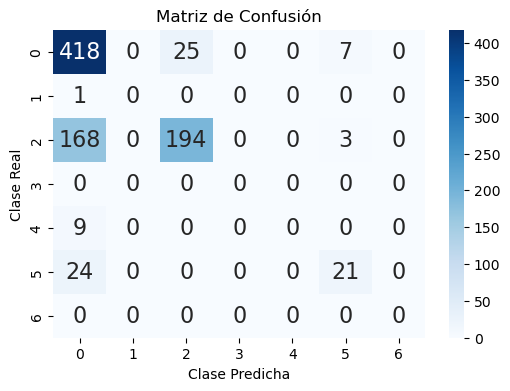

MSE: 0.38275862068965516

 ===================  DECISION TREE  ===================== 

Accuracy :  80.11494252873564 %


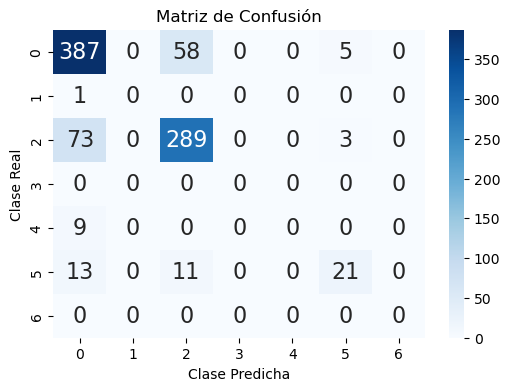

MSE: 0.3471264367816092

 ===================  RANDOM FOREST  ===================== 

Accuracy :  78.27586206896552 %


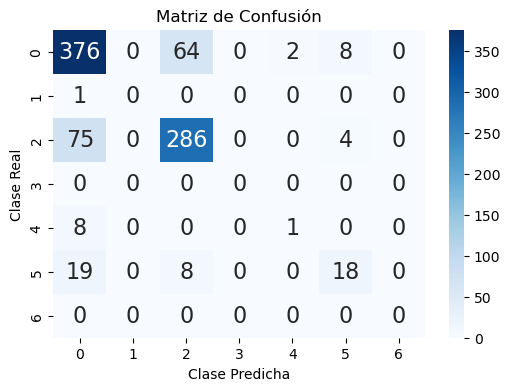

MSE: 0.367816091954023

 ===================  MLP  ===================== 

scores =  [0.07512315 0.08180884 0.06207605 0.08078109 0.07749229]
Our MLP:
Accuracy :  73.44827586206897 %


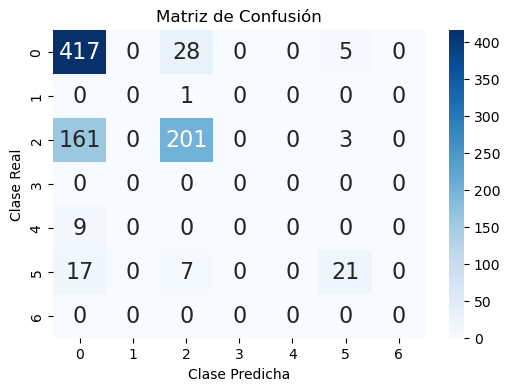

MSE: 0.39195402298850573


SKL MLP:
Accuracy :  71.26436781609196 %


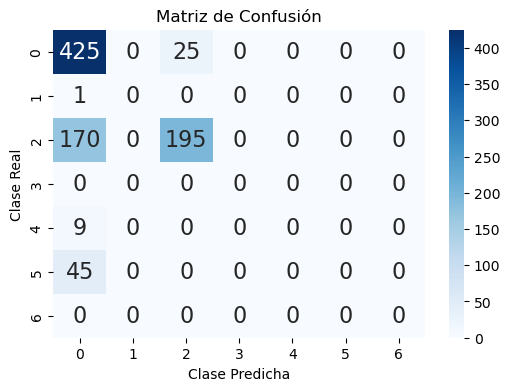

MSE: 0.3873563218390805


In [2]:
# Ignacio Del Castillo Rubio
# Javier Villegas Montelongo

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, make_scorer
import seaborn as sns
import numpy as np
import pandas as pd
from ann import costL2, backprop, forwardprop, iterateThetas

from Utils import ExportThetasToFile
from Utils import CreateTxt
print("\n ======== Loading... =============== \n" )
#print(pd.__version__)

# EJERCICIO 2 - visualiza los datos

# Cargar los datos desde el archivo CSV
data = pd.read_csv("data/kartAllData.csv", header=None, names=["dist1", "dist2", "dist3", "dist4", "dist5", 
                                                           "x", "y", "z", "tiempo", "accion"])

# Eliminar las columnas de posición y tiempo ya que consideramos que no son tan relevantes como la distancia de los raycast
droppingPosition = True

if (droppingPosition):
    cleanDataset = data.drop(["x", "y", "z", "tiempo"], axis=1)
    numInputs = 5
else:
    cleanDataset = data.drop(["y", "tiempo"], axis=1)
    numInputs = 7
    
# Realizar one-hot encoding para la columna "accion"
one_hot_encoded = pd.get_dummies(data["accion"], prefix="accion")

# Añadir los valores generados del one_hot_encoded al dataset
cleanDataset = pd.concat([cleanDataset, one_hot_encoded], axis=1)
cleanDataset = cleanDataset.drop(["accion"], axis=1)

# Utilizaremos los valores de las distancias de los 5 raycast como input
X = cleanDataset.iloc[:, :numInputs]
# Mientras que utilizaremos los 7 estados de accion, pasados por one_hot_encoded
Y = cleanDataset.iloc[:, numInputs:]

# Limitar datos sin sentido
X = np.clip(X, -1, 10)

# O si se quiere especificar una columna
#X['dist2'] = np.where(X['dist2'] > 10, 10, X['dist2'])
#X['dist3'] = np.where(X['dist3'] > 10, 10, X['dist3'])

#==Normalizacion
from sklearn.preprocessing import StandardScaler

scaling=StandardScaler()
scaling.fit(X)
X=scaling.transform(X)


#========================================================================================================
#                    DIVIDIR DATOS ENTRE ENTRENAMIENTO Y DE TEST
#========================================================================================================

from sklearn.model_selection import train_test_split, cross_val_score
X, X_test, Y, Y_test = train_test_split(X, Y, train_size = 0.8, random_state = 1234)


# Visualizar la distribución de clases
class_distribution = data["accion"].value_counts()

# Graficar la distribución de clases
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribución de Clases')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()


# Los valores de Y_pred y Y_test tienen que tener el siguiente formato:
# Y_pred =  [0 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0  ... 0 0 0 0 0 2 0] 
def PrintData(Y_pred, Y_test) :
    # Calcula el accuracy
    acc = accuracy_score(Y_test, Y_pred)
    
    print("Accuracy : ", acc * 100, "%")
    
    from sklearn.metrics import confusion_matrix
    
    Y_test_np = np.array(Y_test, dtype=int)
    Y_pred_np = np.array(Y_pred, dtype=int)
    
    conf_matrix = confusion_matrix(Y_test_np, Y_pred_np, labels=[0, 1, 2, 3, 4, 5, 6])
    
#    print("Matriz de Confusión:")
#    print(conf_matrix)
    
#    print("Matriz de Confusión 2x2:")
#    Y_test_np = np.array(Y_test, dtype=bool)
#    Y_pred_np = np.array(Y_pred, dtype=bool)
#    conf_matrix_bool = confusion_matrix(Y_test_np.flatten(), Y_pred_np.flatten())
#    print(conf_matrix_bool)
    
    # Matriz de confusion con colores
    #cm = confusion_matrix(Y_test, Y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
    plt.xlabel('Clase Predicha')
    plt.ylabel('Clase Real')
    plt.title('Matriz de Confusión')
    plt.show()
    
    # Para calcular el MSE de forma mas coherente, hemos decidido mover estos comandos en este orden 
    # LEFT_ACCELERATE, ACCELERATE, RIGHT_ACCELERATE
    # Para que el error sea mayor entre las direcciones laterales, pero no tan grande respecto al medio
    
    # Mover BRAKE al index -1 (valor auxiliar par no sobreescribir datos)
    Y_pred_aux = Y_pred.copy()
    Y_test_aux = Y_test.copy()
    np.place(Y_pred_aux, Y_pred_aux == 1, -1)
    np.place(Y_test_aux, Y_test_aux == 1, -1)
    # Mover ACCELERATE al index 1
    np.place(Y_pred_aux, Y_pred_aux == 0, 1)
    np.place(Y_test_aux, Y_test_aux == 0, 1)
    # Mover RIGHT_ACCELERATE al index 0
    np.place(Y_pred_aux, Y_pred_aux == 5, 0)
    np.place(Y_test_aux, Y_test_aux == 5, 0)
    # Mover BRAKE al index 5
    np.place(Y_pred_aux, Y_pred_aux == -1, 5)
    np.place(Y_test_aux, Y_test_aux == -1, 5)
    
    # Calcula el Error Cuadrático Medio (MSE)
    mse = mean_squared_error(Y_test_aux, Y_pred_aux)
    print("MSE:", mse)
    

# 0: ACCELERATE
# 1: BRAKE
# 2: LEFT_ACCELERATE
# 3: LEFT_BRAKE
# 4: NONE
# 5: RIGHT_ACCELERATE
# 6: RIGHT_BRAKE

# EJERCICIO 4 - Prueba diferentes modelos de Machine Learning

Y_test = Y_test.to_numpy()
Y_test_floats = np.array(Y_test, dtype=float)
Y_test = np.argmax(Y_test, axis=1)

#========================================================================================================
#                                             SIMILARITY
#========================================================================================================

from sklearn.neighbors import NearestNeighbors

# Crear el modelo de vecinos más cercanos
model = NearestNeighbors(n_neighbors=7, algorithm='auto')
model.fit(X)
# Punto de consulta para encontrar vecinos cercanos
query_point = np.array([[-0.22401113, 2.40533218, -0.06294622, 0.18585261, 0.60490084]])
#query_point = X_test
# Encontrar los vecinos más cercanos
distances, indexes = model.kneighbors(query_point)

print("\n ===================  SIMILARITY  ===================== \n")

# Imprimir los vecinos más cercanos y sus distancias
print("Vecinos más cercanos:")
print(X[indexes])
print("Distancias:")
print(distances)
print("Prediccion de los vecinos mas cercanos:")

Y_values = np.argmax(Y, axis=1)

for index_pair in indexes:
    for index in index_pair:
        print(Y_values[index], end=" ")

print("\n")

#for index in range(len(indexes)):
#    print(Y[indexes[index]], ",")

#========================================================================================================
#                                                SVM
#========================================================================================================

from sklearn.svm import SVC

# Polinómico: (kernel='poly', degree=degree)
# Radial basis function (RBF o Gaussiano): (kernel='rbf')
classifier = SVC(kernel = 'linear', random_state = 0)

SVC_Y_train = np.argmax(Y, axis=1)
classifier = classifier.fit(X, SVC_Y_train)

Y_pred = classifier.predict(X_test)


print("\n ===================  SVM  ===================== \n")

PrintData(Y_pred, Y_test)


#========================================================================================================
#                                            DECISION TREE
#========================================================================================================

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

decision_tree = DecisionTreeClassifier(random_state=0, max_depth=4)

# Entrenar modelo
decision_tree = decision_tree.fit(X, Y)

# DESCOMENTAR PARA PRINTEAR EL ARBOL GENERADO
### # Los nombres de los 5 rayos/parametros
### ray_features = ["ray1", "ray2", "ray3", "ray4", "ray5"]
### r = export_text(decision_tree, feature_names=ray_features)
### print(r)
### decision_tree.score(X_test, Y_test)

# Predice las clases en el conjunto de prueba
Y_pred = decision_tree.predict(X_test)
#print("Y_pred = ", Y_pred[:100])


print("\n ===================  DECISION TREE  ===================== \n")

#Y_pred_floats = np.array(Y_pred, dtype=float)

# Convertir los datos de formato [[true, false, ...], [false, true, ...]] a [0, 2, 2, 1, 0, 0 ...]
Y_pred = np.argmax(Y_pred, axis=1)

PrintData(Y_pred, Y_test)


#========================================================================================================
#                                          RANDOM FOREST
#========================================================================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Supongamos que X e Y son tus datos de entrenamiento
# Supongamos que X_test e Y_test son tus datos de validación

# Crear el modelo de Random Forest
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
random_forest_model.fit(X, Y)

# Realizar predicciones en los datos de validación
Y_pred = random_forest_model.predict(X_test)

print("\n ===================  RANDOM FOREST  ===================== \n")

Y_pred = np.argmax(Y_pred, axis=1)

PrintData(Y_pred, Y_test)

#========================================================================================================
#                                                MLP
#========================================================================================================

# Entrenar modelo con backpropagation

neuronsInputLayer = X.shape[1]
neuronsFirstHiddenLayer = 7
neuronsSecondHiddenLayer = 7
neuronsThirdHiddenLayer = 7
neuronsOutputLayer = Y.shape[1]

e = 0.12
iterations = 5000
myAlpha = 0.5
myLambda = 0.5

np.random.seed(2)
thetas = []
# Valores aleatorios en theta1 y theta2
thetas.append(np.random.uniform(low=-e, high=e, size=( neuronsFirstHiddenLayer, neuronsInputLayer+1)))
thetas.append(np.random.uniform(low=-e, high=e, size=( neuronsSecondHiddenLayer, neuronsFirstHiddenLayer+1)))
#thetas.append(np.random.uniform(low=-e, high=e, size=( neuronsThirdHiddenLayer, neuronsSecondHiddenLayer+1)))
thetas.append(np.random.uniform(low=-e, high=e, size=(neuronsOutputLayer, neuronsSecondHiddenLayer+1)))
#theta3 = np.random.uniform(low=-e, high=e, size=(99, +1))
#theta4 = np.random.uniform(low=-e, high=e, size=(99, +1))

# Ajustar thetha1 y theta2 teniendo en cuenta los parametros dados
thetas = iterateThetas(thetas, X, Y, iterations, myLambda, myAlpha)

#ExportThetasToFile(thetas, "../Assets/modelo1.txt")
# En modelo2 se guarda el sistema entrenado
CreateTxt(thetas, "../Assets/MLP_data.txt")

#=======================================================================================================
#                             COMPARAR LOS RESULTADOS DE MLP CON SKLEARN
#=======================================================================================================

print("\n ===================  MLP  ===================== \n" )
# Entrenar a SKLearn con los mismos valores
from sklearn.neural_network import MLPClassifier

sklearn_neural_network = MLPClassifier(
    alpha=myLambda, 
    learning_rate_init=myAlpha, 
    activation='relu',
    hidden_layer_sizes=(neuronsFirstHiddenLayer, neuronsSecondHiddenLayer),
    max_iter = iterations
)
# Diferentes funciones de activacion
# Relu es mejor para mas capas ocultas
# activation='relu'
# La sigmoidal es mejor para menos capas
# activation='logistic'

# Entrenamiento del MLP
sklearn_neural_network.fit(X, Y)
scores = cross_val_score(sklearn_neural_network, X, Y, cv=5, scoring=make_scorer(mean_squared_error))

print("scores = ", scores )

## Realizar la propagación hacia adelante

# Predicciones con MLPClassifier
layerValues_sklearn = sklearn_neural_network.predict(X_test)
sklearnPredictions = np.argmax(layerValues_sklearn, axis=1)
#print("SklearnPredictions:", sklearnPredictions[:1000])

layerValues, weighted_inputs = forwardprop(thetas, X_test)
#print("layerValues[-1].shape: ", layerValues[-1].shape)
#print("Y_test.shape: ", Y_test.shape)
#print("Y_test: ", Y_test[:100])

myPredictions = np.argmax(layerValues[-1], axis=1)

print("Our MLP:")
PrintData(myPredictions, Y_test)
print("\n")

print("SKL MLP:")
PrintData(sklearnPredictions, Y_test)


Our KNN:
Accuracy :  77.04918032786885 %


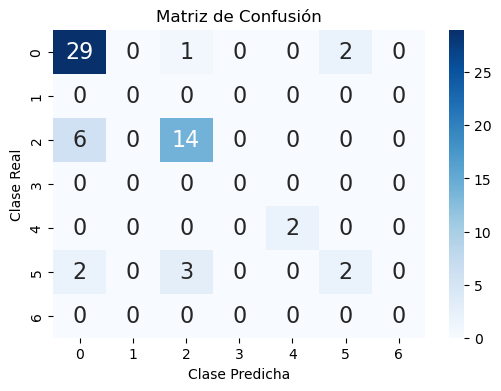

MSE: 0.3770491803278688


SKL KNN:
Accuracy :  72.1311475409836 %


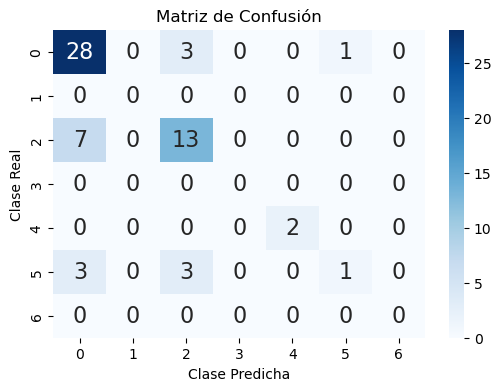

MSE: 0.4262295081967213




In [3]:
from knn import predict
import pandas as pd
import numpy as np

data = pd.read_csv("data/Kart06.csv", header=None)

# Realizar one-hot encoding para la columna "accion"
one_hot_encoded = pd.get_dummies(data[9], prefix="accion")

# Añadir los valores generados del one_hot_encoded al dataset
data = pd.concat([data, one_hot_encoded], axis=1)
data = data.drop([9], axis=1)

X = data.iloc[:, :9].to_numpy()
Y = data.iloc[:, 9:].to_numpy()

# mismo problema que en unity, detectaria distancia 0 y -1 como mas parecidos a 0 y 2
np.place(X, X == -1, 100)


#========DIVIDIR DATOS ENTRE ENTRENAMIENTO Y DE TEST==========================
from sklearn.model_selection import train_test_split, cross_val_score
X, X_test, Y, Y_test = train_test_split(X, Y, train_size = 0.8, random_state = 1234)

Y = np.argmax(Y, axis=1)
Y_test = np.argmax(Y_test, axis=1)

predictions = np.zeros(X_test.shape[0], dtype=int)

for i in range(X_test.shape[0]):
    p = predict(X, Y, X_test[i])
    predictions[i] = p

print("Our KNN:")
PrintData(predictions, Y_test)
print("\n")
    

from sklearn.neighbors import KNeighborsClassifier
knnClssifier = KNeighborsClassifier(n_neighbors=3)
knnClssifier.fit(X, Y)

skPredictions = knnClssifier.predict(X_test)

print("SKL KNN:")
PrintData(skPredictions, Y_test)
print("\n")
    


#========================================================================================================
#                                RAZONAMIENTO FINAL
#========================================================================================================

Tras analizar las metricas y matrices de confusion obtenidas para cada uno de los siguientes modelos:

SVM, DECISION TREE, RANDOM FOREST, MLP. KNN

Creemos que el mejor modelo en este caso es el MLP.
Aunque es notable que a medida que se le incluyen mas capas ocultas, es menos preciso y los resultados observables en Unity son peores.
(En Unity, en la carpeta Assets, esta el MLP generado con 2 capas ocultas(MLP_data.txt) y con una sola (MLP_goodData.txt), la diferencia en conduccion entre los dos es notable).

// KNN
El modelo de KNN esta implementado en este documento tanto con sklearn como una implementacion propia.
Tambien en Unity, se ha implementado el modelo de KNN, teniendo como base de datos el archivo KNNData.cvs

Comparando estos dos modelos en la carrera, podemos observar que aunque KNN completa antes el circuito, si se usa el modelo de MLP con una sola capa oculta (MLP_goodData.txt), dicho modelo es mucho mas eficiente que KNN.

Ademas, KNN y Similarity son sensibles al ruido, lo que es un problema, ya que los casos almacenados pueden contener informacion erronea en algunos instantes de la grabacion, y puede aplicar informacion que se grabo en una situacion especifica en un contexto general, sobretodo usando exclusivamente los datos de los raycast en nuestro caso.
Como puede haber muchos mas casos en un videojuego de este estilo, este modelo puede llegar a ralentizar el juego.

// SVM
Este modelo, aunque genera un 72% de accuracity, no es la mejor opcion en este caso concreto, ya que por un lado no necesitamos un modelo que sea capaz de manejar muchas dimensiones, ya que solo tenemos en cuenta los 5 raycast. Mientras que por otro lado no es eficiente en grandes conjuntos de datos, y un videojuego de este estilo, la grabacion de numerosos datos es esencial.

// DECISION TREE
Aunque este modelo sea facil de interpretar y visualizar, y no requiera normalizacion de datos, es propenso al sobreajuste, lo que no es nada ideal en un videojuego de carreras si se quisiese extender la pista o cambiarla.

// RANDOM FOREST
Este modelo es mas flexible que el decision tree en cuanto a evitar el sobreajuste, aun asi, es sensible al ruido en los datos de entrenamiento, lo que puede suponer un problema.
Tambien es mas lento en comparacion a modelos mas simples, lo que es aceptable hasta cierto punto ya que en un videojuego de carreras el tiempo de reaccion es esencial.

// MLP
El Perceptron Multicapa es el modelo que creemos que es mejor para este caso, ya que es capaz de aprender patrones complejos.
Otro punto a favor es que se adapta bien cuando hay muchos datos de entrenamiento, aunque tome una considerable suma de tiempo.
En este caso, existen muchos datos de entrenamiento, y podria haber muchos mas, por lo que es razonable elegir un modelo que se ajuste a estas condiciones.
Aunque el modelo es bastante sensible a la inicialización de pesos y parámetros (hemos comprobado que el resultado obtenido en Unity viendo el coche varia bastante entre modelos identicos estructuralmente pero que se entrenaron con valores iniciales diferentes), podemos controlar dicha desventaja manipulando la semilla actual con "np.random.seed(2)".

Aunque opinamos que el MLP es la mejor opcion basandonos en las metricas calculadas de los modelos, esto es solo en caso de que el MLP tenga solo una capa oculta, ya que mientras mas capas ocultas tenga peores son los resultados, tando en accuracy como en conduccion en Unity, si usamos la funcion de activacion de ReLu para las capas ocultas, los resultados mejoran, pero siguen sin superar a un modelo de menos capas ocultas.